<h1>Happiness Simulator</h1>

<p>Based on the "Pyramid of needs", I have built a model which calculates a parameter, h, which aproximates the "happiness" of a person. This parameter changes through time, and is calculated through averaging the states of the needs of the pyramid, which can go arbitrarily from -10 to 10, 0 being the neutral state. Each state takes an input at each time step, which can be positive (+1), negative (-1) or neutral (0). This is a discrete model of how happiness and the state of needs are affected by positive or negative events. Just like in the pyramid model, the higher needs will be less susceptible to change (they are less available) if the preceding ones have low state value. Through this system, an event which is absolute becomes scaled by the availability of the needs at a certain time.</p>

In [14]:
import numpy as np
import matplotlib.pyplot as plt

#cuánto valen en el input los eventos positivos y negativos
pos_event = 1
neg_event = -1

#máximo y mínimo de los valores de los estados
y_max = 10
y_min = -10

total_time = 1000
look_back_time = 200
decay_constant = 0.1

"""
show input plot:

fig, ax = plt.subplots()
ax.plot(range(total_time), cats[0].inp)
ax.set(xlabel="time", ylabel="input", title="Input test")
fig.savefig("input_test.png")
plt.show()
"""

'\nshow input plot:\n\nfig, ax = plt.subplots()\nax.plot(range(total_time), cats[0].inp)\nax.set(xlabel="time", ylabel="input", title="Input test")\nfig.savefig("input_test.png")\nplt.show()\n'

In [15]:
#defino categorías (cats) como una lista de objetos Cat
class Cat:
    
    #variable que lleva la cuenta de la id de los objetos Cat
    j = 0
    
    #constructor de Cat
    def __init__(self, cat_list, state=0, availability=1, p_pos_event=0.3, p_neg_event=0.3):
        """
        Inicializo los campos de un Cat específico.
        
        id: número que corresponde a este Cat en la lista cats
        state: estado inicial de este Cat
        availability: disponibilidad de este Cat para tomar un input
        y_max: valor máximo que puede tomar y (el estado)
        y_min: valor mínimo que puede tomar y (el estado)
        p_pos_event: la probabilidad de que suceda un evento positivo en el input
        p_neg_event: la probabilidad de que suceda un evento negativo en el input
        
        y_list: lista en la que guardo todos los valores sucesivos de y
        """
        
        self.id = Cat.j
        Cat.j+=1
        self.cats = cat_list
        
        self.current_state = state
        self.d = availability
        self.p_pos = p_pos_event
        self.p_neg = p_neg_event
        
        self.y_list = np.zeros((total_time - look_back_time, 1))
    
    def generate_input(self, length):
        """
        genera el input de un cierto Cat para todo el trial
        
        length: duración total del trial
        """
        fn = np.zeros((length, 1)) #en fn voy a guardar el input
        for i in range(length):
            r = np.random.rand() #genero un número aleatorio entre 0 y 1
            if(r < self.p_pos): #guardo en fn un evento positivo, negativo o ninguno
                fn[i] = pos_event
            elif(r < self.p_pos + self.p_neg):
                fn[i] = neg_event
        self.inp = fn #el input es ahora fn
    
    def y(self, t):
        """
        calculo y para un cierto tiempo a través de una convolución
        
        t: tiempo actual
        """
        
        if(t<look_back_time): #si no puedo mirar para atrás lo suficiente, me voy
            return 0
        
        result = 0
        for i in range(look_back_time): #voy moviéndome para atrás en el tiempo
            input_value = self.inp[t - i] #tomo el input value de un cierto t
            input_mod = input_value * self.d #lo escalo por la disponibilidad
            filtered = input_mod * np.exp(-i*decay_constant) #miro cuanto decayó hasta ahora
            result += filtered #lo sumo al resultado total
        
        if result > y_max:
            result = y_max
        elif result < y_min:
            result = y_min
        
        self.current_state = result #el resultado es la suma de cómo decayeron todos los inputs
        return result    
    
    def calc_d(self):
        """
        calculo la disponibilidad d
        """
        
        if(self.id == 0): #para la primera cat no cambia la disponibilidad
            return self.d
        
        prev_cat = self.cats[self.id - 1] #miro la cat anterior a esta
        self.d = ((prev_cat.current_state - y_min)/(y_max - y_min))
        #d va linealmente de 0 a 1 dependiendo del estado de la categoría anterior


In [16]:
def simulate(total_time_fn=365*2, look_back_time_fn=200, decay_constant_fn=0.1,
             y_axis="h", plot_name="plot", p_array=[(0.6, 0),
                                                    (0.3, 0.3),(0.3, 0.3),
                                                    (0.3, 0.3),(0.3, 0.3)]):
    """
    corro una simulación completa y muestro el gráfico de h(t).
    
    total_time_fn: tiempo total (en días) de la simmulación.
    look_back_time_fn: tiempo que tengo que mirar hacia atrás para calcular
                    la convolución.
    decay_constant: "velocidad" con la que cae exponencialmente el efecto de
                    un input.
    y_axis: nombre del eje de ordenadas del gráfico.
    plot_name: nombre del gráfico y del archivo correspondiente.
    p_array: lista de tuples que contienen la probabilidad de un evento positivo
             y negativo respectivamente. Al definir esta lista también estoy
             definiendo la cantidad de niveles que tiene el modelo.
    """
    
    total_time = total_time_fn
    look_back_time = look_back_time_fn
    decay_constant = decay_constant_fn
    
    #inicializo todos los cats y h, la felicidad
    cats = []
    for p_pos, p_neg in p_array:
        cats.append(Cat(cat_list=cats, p_pos_event=p_pos, p_neg_event=p_neg))
    
    h = np.zeros((total_time - look_back_time, 1))
    
    #genero inputs para todos los cats
    for cat in cats:
        cat.generate_input(total_time)
    
    #corro la simulación para todo tiempo t desde el primero calculable hasta el último
    for t in range(total_time - look_back_time):
        partial_sum = 0
        
        for cat in cats: #para cada cat, en orden
            cat.calc_d() #calculo la disponibilidad
            cat.y_list[t] = cat.y(look_back_time + t) #calculo el valor del estado
            partial_sum += cat.y_list[t] #sumo ese valor a la suma de todos los estados
        
        h[t] = partial_sum/len(cats) #hago el promedio del valor de todos los estados
    
    #grafico h en función del tiempo
    fig, ax = plt.subplots()
    ax.plot(range(len(h)), h)
    ax.set(xlabel="time", ylabel=y_axis, title=plot_name)
    name = plot_name + ".png"
    fig.savefig(name)
    plt.show()

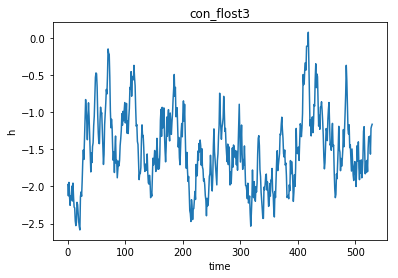

In [17]:
simulate(decay_constant_fn=0.01, plot_name="con_flost3", p_array=[(0.5, 0.5),(0.1, 0.5),(0.1, 0.5),(0.1, 0.5),(0.1, 0.5)])